In [69]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
# MPC import
import numpy as np
from LinearMPC_template.MPCVelControl import MPCVelControl
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")


In [77]:
Ts = 0.05
sim_time = 10
H = 20
x0 = np.zeros(12) # initial state
x0[6] = 5.0  # initial vx
x0[7] = 5.0  # initial vy
x0[8] = 5.0  # initial vz
#on doit changer un des parametres de xo pour mettre une vitesse dans la direction voulue 
# X -> Xo(6) = Vx, Y-> XO(7) = Vy, Z-> Xo(8) = Vz

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, _ = rocket.simulate_control(
    mpc, sim_time, H, x0, method="linear"
)

vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(t_cl[:-1], x_cl[:, :-1], u_cl, T_ol=t_ol[..., :-1], X_ol=x_ol, U_ol=u_ol);

[zvel] nx=1, nu=1, x_ids=[8], u_ids=[2]
Simulating time 0.00: 
 Input Pavg violation: -0.00 < 40.00, 

ValueError: Constraints violation detected, terminating...

In [72]:
from LinearMPC_template.MPCControl_xvel import MPCControl_xvel
xs, us = rocket.trim()
A, B = rocket.linearize(xs, us)
mpc_x = MPCControl_xvel(A, B, xs, us, Ts, H) # Full 12x12 A and 12x4 B matrices
x0_sub = x0[mpc_x.x_ids]   # shape (3,)
u0, x_traj, u_traj = mpc_x.get_u(x0_sub)


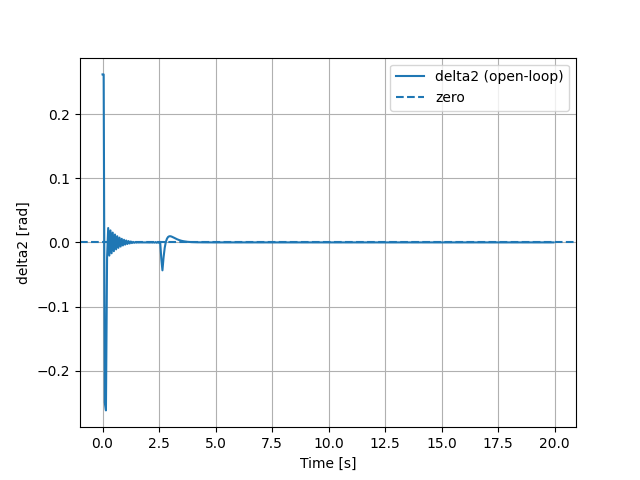

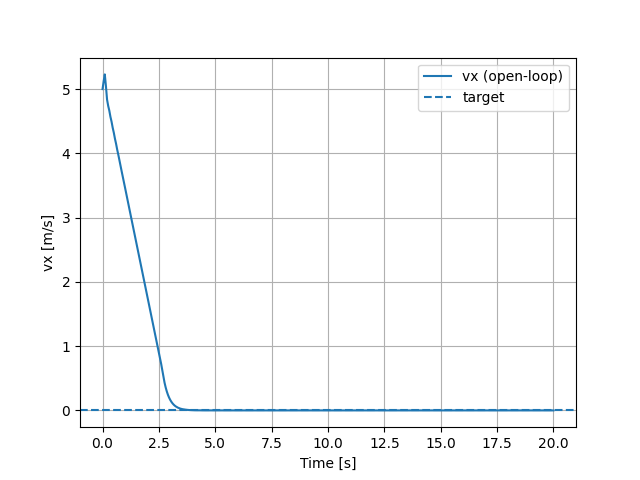

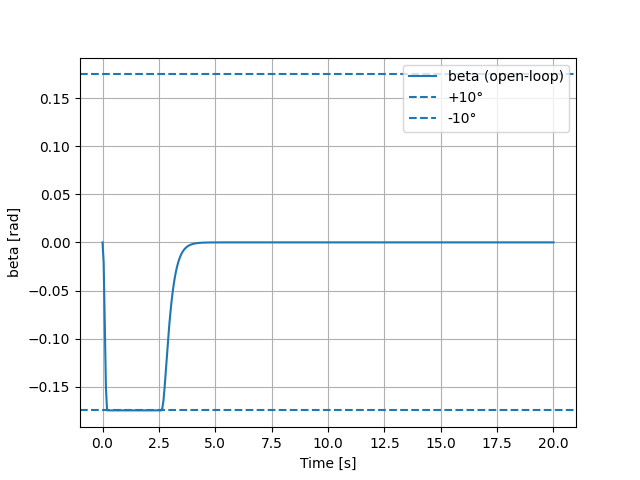

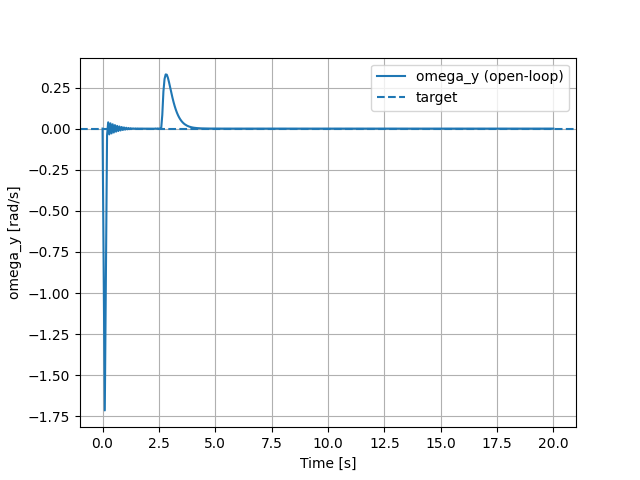

In [73]:
import numpy as np
import matplotlib.pyplot as plt

def plot_x_open_loop(mpc_x, x_traj, u_traj):
    Ts = mpc_x.Ts
    N = mpc_x.N
    t_x = np.arange(N + 1) * Ts
    t_u = np.arange(N) * Ts

    omega_y = x_traj[0, :]
    beta    = x_traj[1, :]
    vx      = x_traj[2, :]
    delta2  = u_traj[0, :]

    beta_max = np.deg2rad(10.0)

    plt.figure()
    plt.plot(t_x, vx, label="vx (open-loop)")
    plt.axhline(0.0, linestyle="--", label="target")
    plt.xlabel("Time [s]")
    plt.ylabel("vx [m/s]")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(t_x, beta, label="beta (open-loop)")
    plt.axhline(+beta_max, linestyle="--", label="+10°")
    plt.axhline(-beta_max, linestyle="--", label="-10°")
    plt.xlabel("Time [s]")
    plt.ylabel("beta [rad]")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(t_x, omega_y, label="omega_y (open-loop)")
    plt.axhline(0.0, linestyle="--", label="target")
    plt.xlabel("Time [s]")
    plt.ylabel("omega_y [rad/s]")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(t_u, delta2, label="delta2 (open-loop)")
    plt.axhline(0.0, linestyle="--", label="zero")
    plt.xlabel("Time [s]")
    plt.ylabel("delta2 [rad]")
    plt.grid(True)
    plt.legend()

# call it
plot_x_open_loop(mpc_x, x_traj, u_traj)
plt.show()


ValueError: x has 601 columns but y has 600 columns

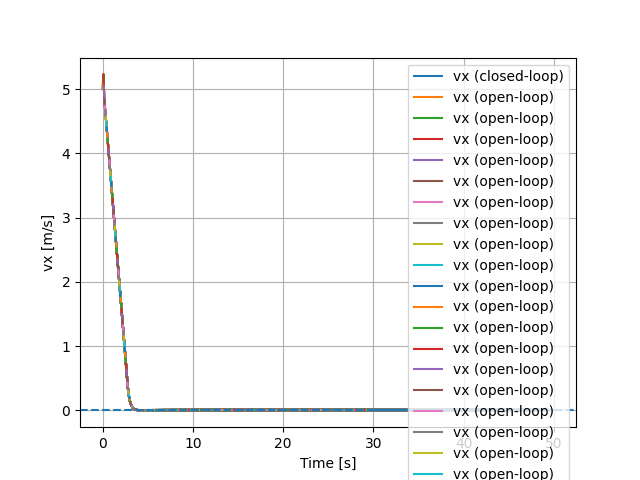

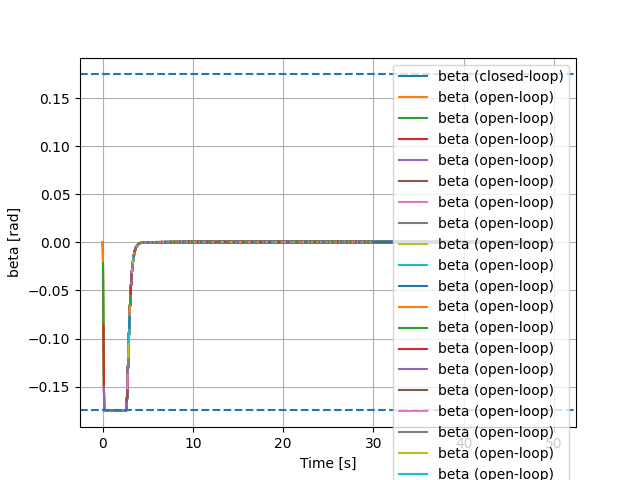

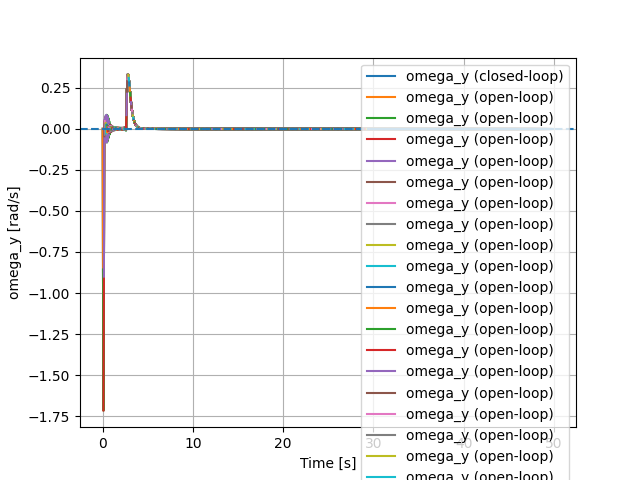

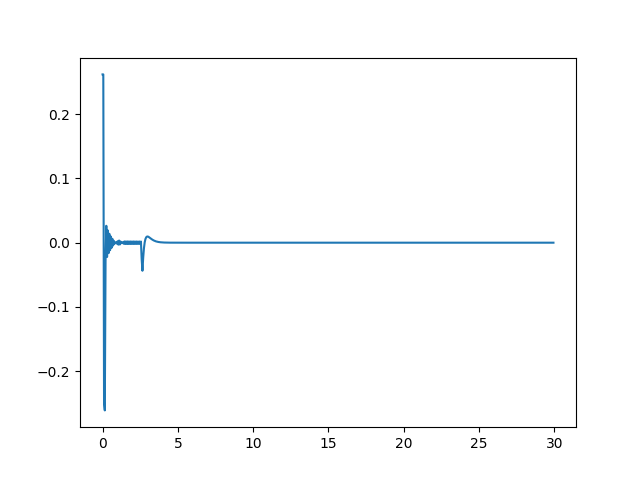

In [75]:
def plot_x_closed_loop(t_cl, x_cl, u_cl, t_ol=None, x_ol=None, u_ol=None):
    IDX_OMEGA_Y = 1
    IDX_BETA = 4
    IDX_VX = 6
    IDX_DELTA2 = 1

    beta_max = np.deg2rad(10.0)

    # closed-loop
    omega_y_cl = x_cl[IDX_OMEGA_Y, :]
    beta_cl    = x_cl[IDX_BETA, :]
    vx_cl      = x_cl[IDX_VX, :]
    delta2_cl  = u_cl[IDX_DELTA2, :]
    t_u_cl     = t_cl[:delta2_cl.shape[0]]

    # open-loop (from simulator, optional)
    have_ol = (t_ol is not None) and (x_ol is not None) and (u_ol is not None)
    if have_ol:
        omega_y_ol = x_ol[IDX_OMEGA_Y, :]
        beta_ol    = x_ol[IDX_BETA, :]
        vx_ol      = x_ol[IDX_VX, :]
        delta2_ol  = u_ol[IDX_DELTA2, :]
        t_u_ol     = t_ol[:delta2_ol.shape[0]]

    plt.figure()
    plt.plot(t_cl, vx_cl, label="vx (closed-loop)")
    if have_ol:
        plt.plot(t_ol, vx_ol, label="vx (open-loop)")
    plt.axhline(0.0, linestyle="--", label="target")
    plt.xlabel("Time [s]")
    plt.ylabel("vx [m/s]")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(t_cl, beta_cl, label="beta (closed-loop)")
    if have_ol:
        plt.plot(t_ol, beta_ol, label="beta (open-loop)")
    plt.axhline(+beta_max, linestyle="--", label="+10°")
    plt.axhline(-beta_max, linestyle="--", label="-10°")
    plt.xlabel("Time [s]")
    plt.ylabel("beta [rad]")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(t_cl, omega_y_cl, label="omega_y (closed-loop)")
    if have_ol:
        plt.plot(t_ol, omega_y_ol, label="omega_y (open-loop)")
    plt.axhline(0.0, linestyle="--", label="target")
    plt.xlabel("Time [s]")
    plt.ylabel("omega_y [rad/s]")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(t_u_cl, delta2_cl, label="delta2 (closed-loop)")
    if have_ol:
        plt.plot(t_u_ol, delta2_ol, label="delta2 (open-loop)")
    plt.axhline(0.0, linestyle="--", label="zero")
    plt.xlabel("Time [s]")
    plt.ylabel("delta2 [rad]")
    plt.grid(True)
    plt.legend()

# call it
plot_x_closed_loop(t_cl, x_cl, u_cl, t_ol=t_ol, x_ol=x_ol, u_ol=u_ol)
plt.show()


In [76]:
import matplotlib.pyplot as plt

Xf = mpc_x.xf  # however you store it

fig, ax = plt.subplots()
Xf.projection(dims=(0,1)).plot(ax=ax)
ax.set_xlabel("omega_y")
ax.set_ylabel("beta")
ax.grid(True)

fig, ax = plt.subplots()
Xf.projection(dims=(1,2)).plot(ax=ax)
ax.set_xlabel("beta")
ax.set_ylabel("vx")
ax.grid(True)

plt.show()


AttributeError: 'MPCControl_xvel' object has no attribute 'xf'